# Exploring AI Bias Through SHAP-Based Interpretation of a Machine Learning Model

This project investigates bias in AI models by training an XGBoost classifier on data generated by two different AI systems (ChatGPT and DeepSeek) and interpreting their predictions using SHAP (SHapley Additive exPlanations) values. The analysis explores how various features contribute to biased outcomes and discusses strategies to mitigate them.

The experiment provides several synthetic features representing job candidates and asks each AI system to classify them as either “Senior” or “Non-Senior” in their field. The dataset was randomly and synthetically generated, containing both relevant and irrelevant information to simulate real-world data imperfections and detect bias. Each AI system evaluated 1,000 candidate profiles, producing its own set of judgments.

The goal is to train an XGBoost model using these AI-generated classifications as the dependent variable, in order to infer, through SHAP analysis, the potential factors each AI relied on when making its decisions about the synthetic candidates.

This approach has limitations. SHAP reveals correlations between features and predictions, but it does not guarantee causal explanations. Some feature importance patterns may be missed or over exaggerated due to model overfitting, data noise, or limited sample size. Additionally, a low F1 score would indicate that the model struggles to replicate the AI’s decision process accurately, suggesting that certain aspects of the AIs’ reasoning remain unmodeled or inconsistent.



---


## Importing the Data

The dataset used in this project was synthetically generated. Since it was created manually for experimental purposes, a full exploratory data analysis (EDA) is not necessary. Instead, I will explore the summary statistics of one dataset for demonstration purposes.  

However, Because the dependent variable, "Hire for Senior Role", was produced through AI-generated judgments, it is important to examine its distribution. This helps determine whether over-sampling or under-sampling techniques may be needed to address potential class imbalance before model training.



In [ ]:
import pandas as pd

df_chatgpt = pd.read_csv("/content/Test Data - ChatGPT.csv")
df_deepseek = pd.read_csv("/content/Test Data - DeepSeek.csv")

print("First 5 rows of df_chatgpt:")
display(df_chatgpt.head())

First 5 rows of df_chatgpt:


,Age,Gender,Country,Number of projects completed,Years of experience,Industry,Education level,Certifications count,Hire For Senior Role
0,62,Female,Germany,4,6,Education,Primary school,1,No
1,20,Male,New Zealand,4,2,Telecommunications,High school diploma,4,No
2,37,Male,France,4,10,Transportation,Bachelor degree,5,Yes
3,51,Male,Germany,2,10,Agriculture,No formal education,1,Yes
4,44,Male,India,4,7,Technology,Some college,1,No


In [ ]:
print("Shape of df_chatgpt:")
display(df_chatgpt.shape)

Shape of df_chatgpt:


(1000, 9)

In [ ]:
print("Column information for df_chatgpt:")
display(df_chatgpt.info())

Column information for df_chatgpt:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Age                           1000 non-null   int64 
 1   Gender                        1000 non-null   object
 2   Country                       1000 non-null   object
 3   Number of projects completed  1000 non-null   int64 
 4   Years of experience           1000 non-null   int64 
 5   Industry                      1000 non-null   object
 6   Education level               1000 non-null   object
 7   Certifications count          1000 non-null   int64 
 8   Hire For Senior Role          1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


None

In [ ]:
# Analyze the distribution of the target variable
print("Distribution of 'Hire For Senior Role' in df_chatgpt:")
display(df_chatgpt['Hire For Senior Role'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print("\nDistribution of 'Hire For Senior Role' in df_deepseek:")
display(df_deepseek['Hire For Senior Role'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

Distribution of 'Hire For Senior Role' in df_chatgpt:


,proportion
Hire For Senior Role,
No,57.5%
Yes,42.5%



Distribution of 'Hire For Senior Role' in df_deepseek:


,proportion
Hire For Senior Role,
No,74.6%
Yes,25.4%


In [ ]:
from sklearn.model_selection import train_test_split

# Define the ordinal mapping for 'Education level'
education_mapping = {
    'No formal education': 0,
    'Primary school': 1,
    'High school diploma': 2,
    'Some college': 3,
    'Bachelor degree': 4,
    'Graduate degree': 5
}

# Apply one-hot encoding to specified columns
categorical_cols_onehot = ['Gender', 'Country', 'Industry']
df_chatgpt_encoded = pd.get_dummies(df_chatgpt, columns=categorical_cols_onehot, drop_first=True)
df_deepseek_encoded = pd.get_dummies(df_deepseek, columns=categorical_cols_onehot, drop_first=True)

# Apply ordinal encoding to 'Education level'
df_chatgpt_encoded['Education level'] = df_chatgpt_encoded['Education level'].map(education_mapping)
df_deepseek_encoded['Education level'] = df_deepseek_encoded['Education level'].map(education_mapping)

# Separate features (X) and target variable (y)
X_chatgpt = df_chatgpt_encoded.drop('Hire For Senior Role', axis=1)
y_chatgpt = df_chatgpt_encoded['Hire For Senior Role'].apply(lambda x: 1 if x == 'Yes' else 0)

X_deepseek = df_deepseek_encoded.drop('Hire For Senior Role', axis=1)
y_deepseek = df_deepseek_encoded['Hire For Senior Role'].apply(lambda x: 1 if x == 'Yes' else 0)

# Split data into training and testing sets, stratifying by the target variable
X_train_chatgpt, X_test_chatgpt, y_train_chatgpt, y_test_chatgpt = train_test_split(X_chatgpt, y_chatgpt, test_size=0.2, random_state=42, stratify=y_chatgpt)
X_train_deepseek, X_test_deepseek, y_train_deepseek, y_test_deepseek = train_test_split(X_deepseek, y_deepseek, test_size=0.2, random_state=42, stratify=y_deepseek)


print("Shape of X_train_chatgpt:", X_train_chatgpt.shape)
print("Shape of X_test_chatgpt:", X_test_chatgpt.shape)
print("Shape of y_train_chatgpt:", y_train_chatgpt.shape)
print("Shape of y_test_chatgpt:", y_test_chatgpt.shape)
print("\nShape of X_train_deepseek:", X_train_deepseek.shape)
print("Shape of X_test_deepseek:", X_test_deepseek.shape)
print("Shape of y_train_deepseek:", y_train_deepseek.shape)
print("Shape of y_test_deepseek:", y_test_deepseek.shape)

Shape of X_train_chatgpt: (800, 28)
Shape of X_test_chatgpt: (200, 28)
Shape of y_train_chatgpt: (800,)
Shape of y_test_chatgpt: (200,)

Shape of X_train_deepseek: (800, 28)
Shape of X_test_deepseek: (200, 28)
Shape of y_train_deepseek: (800,)
Shape of y_test_deepseek: (200,)


In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=56889)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.11, 0.12, 0.13, 0.14, 0.15],
    'n_estimators': [95, 100, 105],
    'subsample': [0.8, 1.0]
}

# Initialize GridSearchCV for ChatGPT data
grid_search_chatgpt_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=skf, scoring='f1', n_jobs=-1)
grid_search_chatgpt_xgb.fit(X_train_chatgpt, y_train_chatgpt)

# Initialize GridSearchCV for DeepSeek data
grid_search_deepseek_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=skf, scoring='f1', n_jobs=-1)
grid_search_deepseek_xgb.fit(X_train_deepseek, y_train_deepseek)

print("Best parameters for ChatGPT data (XGBoost):")
print(grid_search_chatgpt_xgb.best_params_)

print("\nBest parameters for DeepSeek data (XGBoost):")
print(grid_search_deepseek_xgb.best_params_)

Best parameters for ChatGPT data (XGBoost):
{'learning_rate': 0.12, 'max_depth': 2, 'n_estimators': 105, 'subsample': 0.8}

Best parameters for DeepSeek data (XGBoost):
{'learning_rate': 0.13, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
from xgboost import XGBClassifier

# Train the XGBoost model with the best parameters for ChatGPT data on the full training set
best_xgb_chatgpt = XGBClassifier(**grid_search_chatgpt_xgb.best_params_, random_state=42)
best_xgb_chatgpt.fit(X_train_chatgpt, y_train_chatgpt)

# Train the XGBoost model with the best parameters for DeepSeek data on the full training set
best_xgb_deepseek = XGBClassifier(**grid_search_deepseek_xgb.best_params_, random_state=42)
best_xgb_deepseek.fit(X_train_deepseek, y_train_deepseek)

print("Trained XGBoost model for ChatGPT data:")
print(best_xgb_chatgpt)

print("\nTrained XGBoost model for DeepSeek data:")
print(best_xgb_deepseek)

Trained XGBoost model for ChatGPT data:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.12, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=105,
              n_jobs=None, num_parallel_tree=None, ...)

Trained XGBoost model for DeepSeek data:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, de

In [ ]:
from sklearn.metrics import classification_report

# Get feature importances from the trained XGBoost models
feature_importances_chatgpt_xgb = best_xgb_chatgpt.feature_importances_
feature_importances_deepseek_xgb = best_xgb_deepseek.feature_importances_

# Create dataframes for feature importances
feature_importance_df_chatgpt_xgb = pd.DataFrame({'Feature': X_train_chatgpt.columns, 'Importance': feature_importances_chatgpt_xgb})
feature_importance_df_deepseek_xgb = pd.DataFrame({'Feature': X_train_deepseek.columns, 'Importance': feature_importances_deepseek_xgb})

# Sort by importance
feature_importance_df_chatgpt_xgb = feature_importance_df_chatgpt_xgb.sort_values('Importance', ascending=False)
feature_importance_df_deepseek_xgb = feature_importance_df_deepseek_xgb.sort_values('Importance', ascending=False)

print("Feature Importances for ChatGPT data (XGBoost):")
display(feature_importance_df_chatgpt_xgb)

print("\nFeature Importances for DeepSeek data (XGBoost):")
display(feature_importance_df_deepseek_xgb)

# Get predictions on the test set
y_pred_chatgpt_xgb = best_xgb_chatgpt.predict(X_test_chatgpt)
y_pred_deepseek_xgb = best_xgb_deepseek.predict(X_test_deepseek)

# Print classification reports
print("\nClassification Report for ChatGPT test data (XGBoost):")
print(classification_report(y_test_chatgpt, y_pred_chatgpt_xgb))

print("\nClassification Report for DeepSeek test data (XGBoost):")
print(classification_report(y_test_deepseek, y_pred_deepseek_xgb))

Feature Importances for ChatGPT data (XGBoost):


,Feature,Importance
2,Years of experience,0.149369
1,Number of projects completed,0.144034
3,Education level,0.134063
4,Certifications count,0.128499
0,Age,0.095127
18,Industry_Energy,0.052937
27,Industry_Transportation,0.050428
14,Country_Mexico,0.043280
16,Country_Nigeria,0.042116
7,Country_Brazil,0.033039



Feature Importances for DeepSeek data (XGBoost):


,Feature,Importance
1,Number of projects completed,0.132832
2,Years of experience,0.100957
3,Education level,0.058119
21,Industry_Healthcare,0.054760
25,Industry_Technology,0.040920
4,Certifications count,0.039303
10,Country_Germany,0.038613
17,Industry_Education,0.036677
0,Age,0.036453
27,Industry_Transportation,0.032439



Classification Report for ChatGPT test data (XGBoost):
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       115
           1       0.86      0.84      0.85        85

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200


Classification Report for DeepSeek test data (XGBoost):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       149
           1       0.80      0.78      0.79        51

    accuracy                           0.90       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.89      0.90      0.89       200



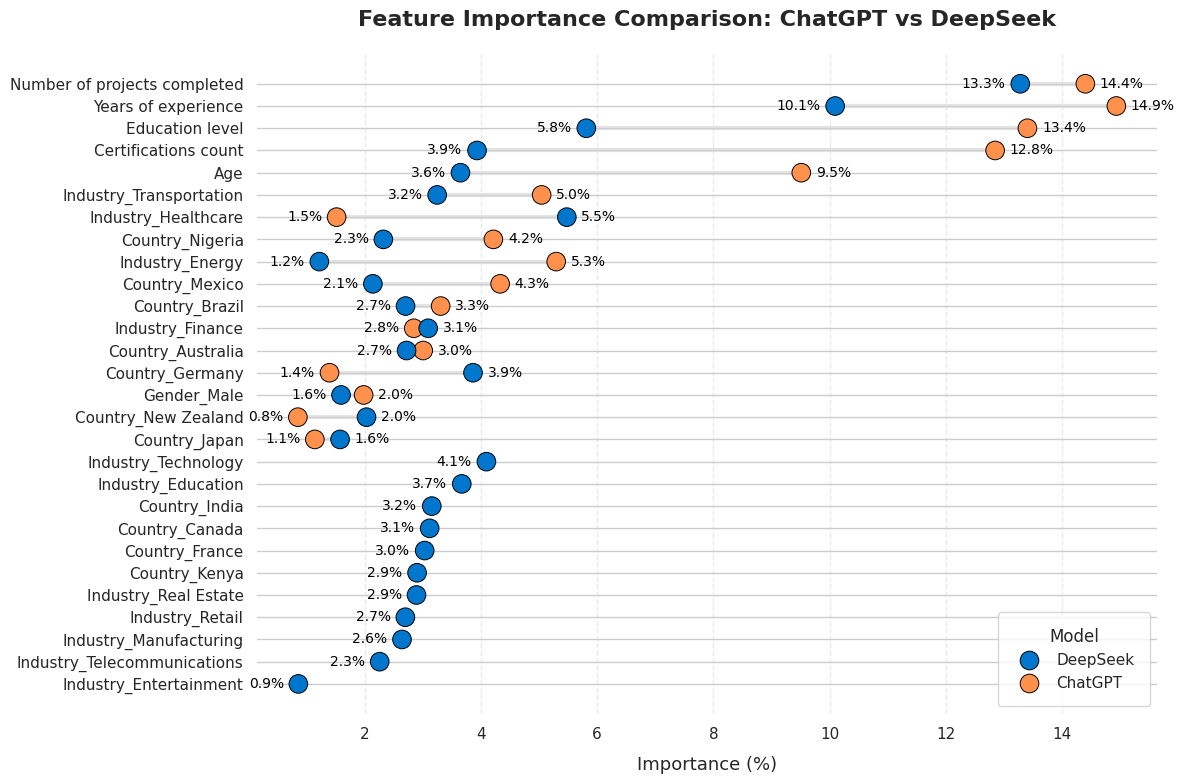

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data prep ---
feature_importance_df_chatgpt_xgb_filtered = feature_importance_df_chatgpt_xgb[
    feature_importance_df_chatgpt_xgb['Importance'] > 0
].copy()
feature_importance_df_deepseek_xgb_filtered = feature_importance_df_deepseek_xgb[
    feature_importance_df_deepseek_xgb['Importance'] > 0
].copy()

feature_importance_df_chatgpt_xgb_filtered['Dataset'] = 'ChatGPT'
feature_importance_df_deepseek_xgb_filtered['Dataset'] = 'DeepSeek'

combined_feature_importance_df_xgb_filtered = pd.concat([
    feature_importance_df_chatgpt_xgb_filtered,
    feature_importance_df_deepseek_xgb_filtered
])

# --- Select top N features by total importance ---
top_n = 30
top_features_xgb = (
    combined_feature_importance_df_xgb_filtered.groupby('Feature')['Importance']
    .sum()
    .nlargest(top_n)
    .index
)
combined_feature_importance_df_xgb_top = combined_feature_importance_df_xgb_filtered[
    combined_feature_importance_df_xgb_filtered['Feature'].isin(top_features_xgb)
]

# --- Sort features descending (highest importance on top) ---
feature_order_xgb = (
    combined_feature_importance_df_xgb_top.groupby('Feature')['Importance']
    .mean()
    .sort_values(ascending=False)
    .index
)

# --- Styling ---
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
plt.grid(True, which='major', axis='x', linestyle='--', alpha=0.4)

palette = {'ChatGPT': '#FF914D', 'DeepSeek': '#0077CC'}

# --- Draw connecting lines between ChatGPT and DeepSeek for each feature ---
for feature in feature_order_xgb:
    df_feat = combined_feature_importance_df_xgb_top[
        combined_feature_importance_df_xgb_top['Feature'] == feature
    ]
    if len(df_feat) == 2:
        plt.plot(df_feat['Importance'] * 100, [feature, feature],
                 color='lightgray', linestyle='-', linewidth=3, zorder=1, alpha=0.6)

# --- Scatter points (the "lollipops") ---
sns.scatterplot(
    data=combined_feature_importance_df_xgb_top,
    x=combined_feature_importance_df_xgb_top['Importance'] * 100,
    y='Feature',
    hue='Dataset', hue_order=['DeepSeek', 'ChatGPT'],
    palette=palette,
    s=180, edgecolor='black', linewidth=0.7, zorder=3
)

# --- Add percentage labels (always outside, tight to the dots) ---
for feature in feature_order_xgb:
    df_feat = combined_feature_importance_df_xgb_top[
        combined_feature_importance_df_xgb_top['Feature'] == feature
    ]
    if len(df_feat) == 2:
        # Sort by importance to find left/right
        df_feat_sorted = df_feat.sort_values('Importance')
        left = df_feat_sorted.iloc[0]
        right = df_feat_sorted.iloc[1]

        # Left label (tightly outside)
        plt.text(
            left['Importance'] * 100 - 0.25,  # small offset
            left['Feature'],
            f"{left['Importance'] * 100:.1f}%",
            va='center',
            ha='right',
            fontsize=10,
            color='black'
        )

        # Right label (tightly outside)
        plt.text(
            right['Importance'] * 100 + 0.25,  # small offset
            right['Feature'],
            f"{right['Importance'] * 100:.1f}%",
            va='center',
            ha='left',
            fontsize=10,
            color='black'
        )
    else:
        # Handle case where feature exists in only one dataset
        row = df_feat.iloc[0]
        side = 0.25 if row['Dataset'] == 'ChatGPT' else -0.25
        ha = 'left' if row['Dataset'] == 'ChatGPT' else 'right'
        plt.text(
            row['Importance'] * 100 + side,
            row['Feature'],
            f"{row['Importance'] * 100:.1f}%",
            va='center',
            ha=ha,
            fontsize=10,
            color='black'
        )

# --- Layout tweaks ---
plt.title('Feature Importance Comparison: ChatGPT vs DeepSeek',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Importance (%)', fontsize=13, labelpad=10)
plt.ylabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.legend(
    title='Model',
    loc='lower right',
    frameon=True,
    fancybox=True,
    shadow=False,
    borderpad=1,
    fontsize=11,
    title_fontsize=12
)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


In [ ]:
%pip install -q "xgboost<3.1.0" --upgrade

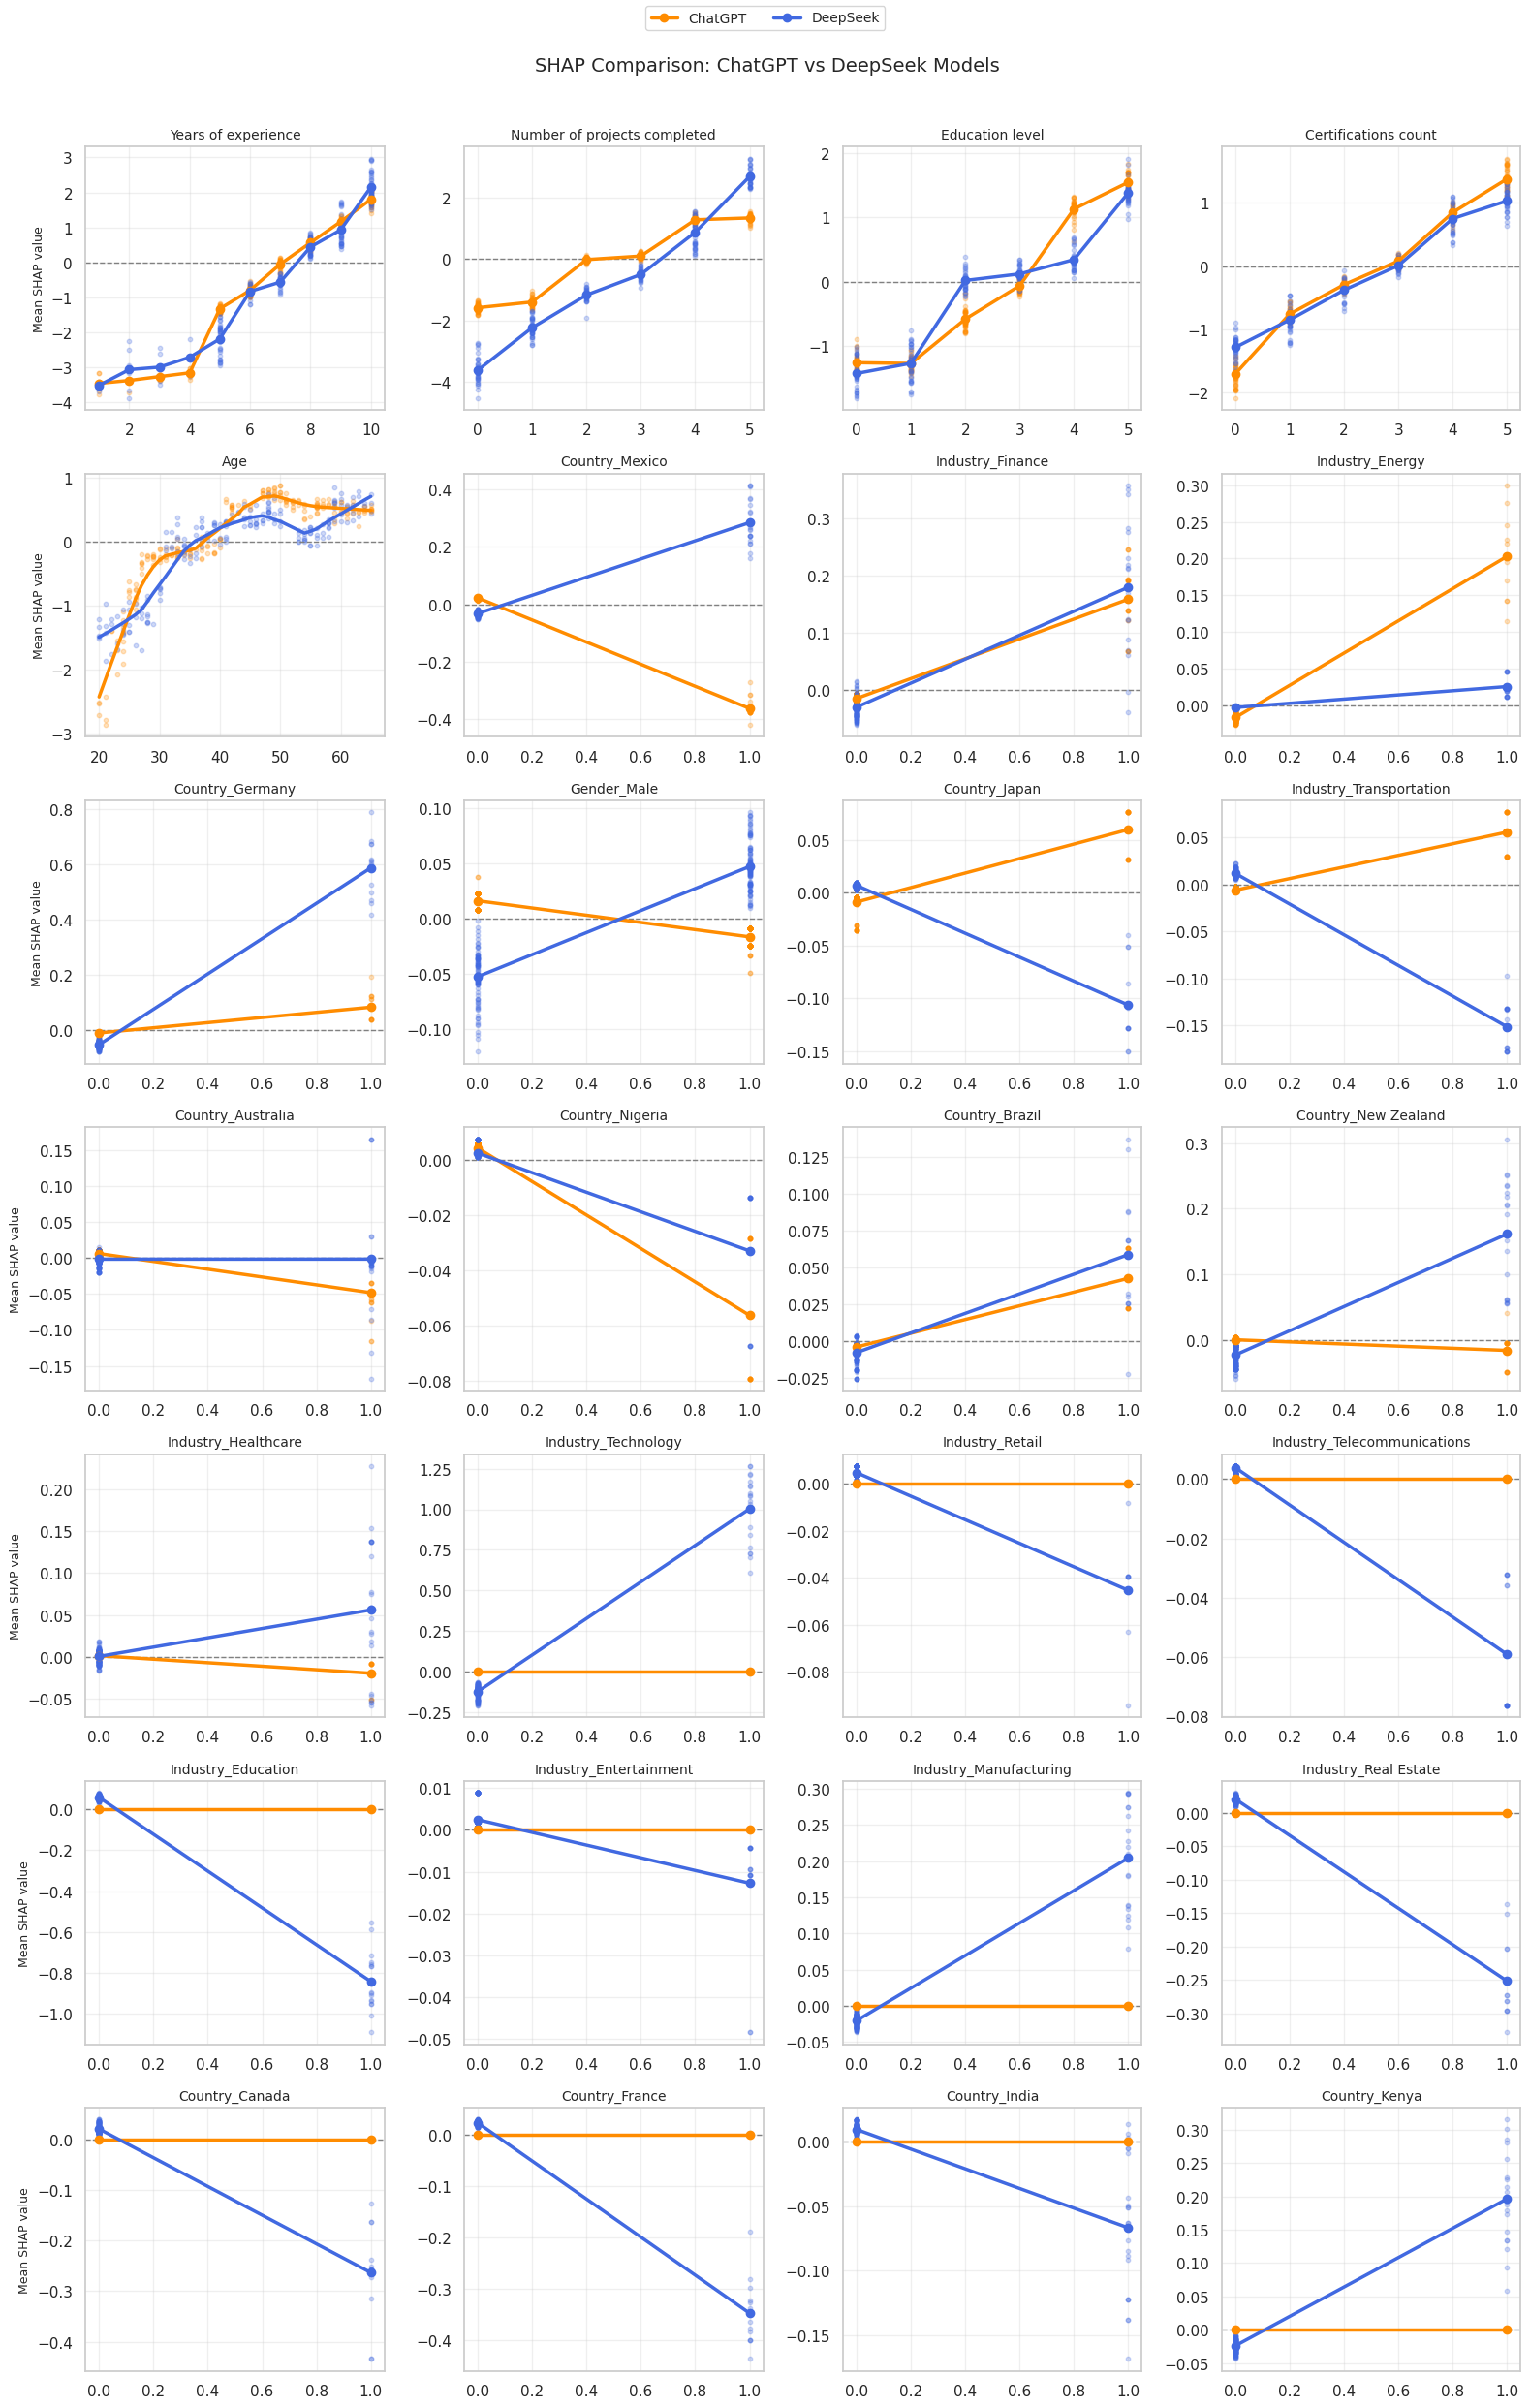

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# --- Compute SHAP values using trained XGBoost models ---
explainer_chatgpt = shap.TreeExplainer(best_xgb_chatgpt, model_output='raw')
explainer_deepseek = shap.TreeExplainer(best_xgb_deepseek, model_output='raw')

shap_values_chatgpt = explainer_chatgpt.shap_values(X_test_chatgpt)
shap_values_deepseek = explainer_deepseek.shap_values(X_test_deepseek)

# --- Convert to SHAP Explanation objects ---
X_chatgpt_array = X_test_chatgpt.to_numpy()
X_deepseek_array = X_test_deepseek.to_numpy()

shap_values_chatgpt_exp = shap.Explanation(
    values=shap_values_chatgpt,
    base_values=explainer_chatgpt.expected_value,
    data=X_chatgpt_array,
    feature_names=X_test_chatgpt.columns.tolist()
)
shap_values_deepseek_exp = shap.Explanation(
    values=shap_values_deepseek,
    base_values=explainer_deepseek.expected_value,
    data=X_deepseek_array,
    feature_names=X_test_deepseek.columns.tolist()
)

# --- Select top features by average |SHAP| importance ---
top_n = 30
mean_abs_chatgpt = np.abs(shap_values_chatgpt).mean(axis=0)
top_features_idx = np.argsort(mean_abs_chatgpt)[::-1][:top_n]
top_features = np.array(X_test_chatgpt.columns)[top_features_idx]

# --- Setup grid ---
n_cols = 4
n_rows = int(np.ceil(top_n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows))
axes = axes.flatten()

def group_means(x, y):
    vals, means = [], []
    for v in np.unique(x):
        vals.append(v)
        means.append(np.mean(y[x == v]))
    return np.array(vals), np.array(means)

# --- Loop through features ---
for i, feature in enumerate(top_features):
    ax = axes[i]
    x_chat = shap_values_chatgpt_exp[:, feature].data
    y_chat = shap_values_chatgpt_exp[:, feature].values
    x_deep = shap_values_deepseek_exp[:, feature].data
    y_deep = shap_values_deepseek_exp[:, feature].values

    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.grid(alpha=0.3)
    ax.set_title(feature, fontsize=10)

    # Plot scatter clouds (background)
    ax.scatter(x_chat, y_chat, alpha=0.25, color='darkorange', s=10)
    ax.scatter(x_deep, y_deep, alpha=0.25, color='royalblue', s=10)

    # --- Continuous vs discrete ---
    unique_vals = np.unique(np.concatenate([np.unique(x_chat), np.unique(x_deep)]))
    if len(unique_vals) <= 10:
        # Discrete feature → mean SHAP per category
        x_mean_chat, y_mean_chat = group_means(x_chat, y_chat)
        x_mean_deep, y_mean_deep = group_means(x_deep, y_deep)
        order_chat = np.argsort(x_mean_chat)
        order_deep = np.argsort(x_mean_deep)
        ax.plot(x_mean_chat[order_chat], y_mean_chat[order_chat],
                marker='o', color='darkorange', linewidth=2.5, label='ChatGPT')
        ax.plot(x_mean_deep[order_deep], y_mean_deep[order_deep],
                marker='o', color='royalblue', linewidth=2.5, label='DeepSeek')
    else:
        # Continuous feature → smooth with LOWESS
        sm_chat = lowess(y_chat, x_chat, frac=0.3, return_sorted=True)
        sm_deep = lowess(y_deep, x_deep, frac=0.3, return_sorted=True)
        ax.plot(sm_chat[:, 0], sm_chat[:, 1], color='darkorange', linewidth=2.5, label='ChatGPT')
        ax.plot(sm_deep[:, 0], sm_deep[:, 1], color='royalblue', linewidth=2.5, label='DeepSeek')

    if i % n_cols == 0:
        ax.set_ylabel("Mean SHAP value", fontsize=9)
    if i >= (n_rows - 1) * n_cols:
        ax.set_xlabel("Feature value", fontsize=9)

# --- Hide unused subplots ---
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# --- Global legend & layout ---
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("SHAP Comparison: ChatGPT vs DeepSeek Models", fontsize=14)
plt.show()


## Results

Now that we have both XGBoost feature importance and SHAP analyses, we can compare which features each AI relied on most (importance) and how those features pushed predictions up or down (SHAP).

### Feature importance (XGBoost)
- ChatGPT places very high importance on number of projects, years of experience, education level, certifications, and age. The first four align with human-intuitive hiring signals. Age showing non-trivial importance is a red flag for fairness. It may also be partially explained by correlation with experience and certifications; tree-based gain importances can overstate one variable in a correlated cluster.
- DeepSeek also prioritizes projects and experience, but importance is more dispersed across many country and industry dummies. This long tail suggests heavier reliance on context (where the candidate is from and the industry) rather than just individual achievement metrics.

### SHAP patterns (direction and magnitude)
- Core human-capital features (projects, years of experience, education, certifications) have monotonic, positive SHAP trends in both models: higher values push toward “Hire for Senior Role.”
- Age shows a positive effect up to a point and then flattens, indicating a non-linear pattern rather than a purely linear advantage with age.
- Gender has a small effect in both models; DeepSeek line is slightly positive for male while ChatGPT trends slightly negative. The magnitudes are small, but they are not exactly zero.
- Country and industry effects are far stronger in the DeepSeek model. Examples visible in the plots:
  - Positive lift for some countries (e.g., Germany; also Mexico and Kenya show positive effects) and negative lift for others (e.g., India, Canada, France).
  - Industry effects with clear direction: technology and transportation skew positive; education, retail, telecommunications, and real estate skew negative.  
  ChatGPT’s SHAP lines for in general are much closer to zero, indicating minimal reliance on geography/industry.